# Notebook Title - Sentiment Classification using LSTM

In this notebook, we will perform sentiment classification on IMDB Review Dataset using LSTMs.

We will cover the following steps in this notebook

1) Custom Dataset Loader

2) Word2Vec Embedding Model Training

3) Dataset EDA

4) Custom Training Loop

5) LSTM and Bidirectional LSTM Model Training

Link to Dataset - https://ai.stanford.edu/~amaas/data/sentiment/

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import vocab
from torchtext import data
import torchtext.transforms as T
from torch.utils.data import Dataset, DataLoader
from gensim.models import Word2Vec
from torchtext.data.utils import get_tokenizer
import torch.nn.functional as nnF
import spacy

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
from glob import glob
from collections import defaultdict
from wordcloud import WordCloud
from collections import OrderedDict

from tqdm import tqdm
import datetime
from sklearn.metrics import precision_recall_fscore_support
import pickle
import os
import shutil
import random

In [6]:
!pip install torchinfo
import torchinfo

In [7]:
!pip install torchmetrics
from torchmetrics import ConfusionMatrix, ROC

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 13.7 MB/s eta 0:00:00


In [ ]:
! wget -O aclImdb_v1.tar.gz https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz && tar -xvzf aclImdb_v1.tar.gz -C /content && rm aclImdb_v1.tar.gz

In [9]:
! cat "/content/aclImdb/README"

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a scor

In [10]:
dataset_path = "/content/aclImdb"

In [11]:
train_path = dataset_path + "/train"
test_path = dataset_path + "/test"

positive_path = dataset_path + "/pos"
negative_path = dataset_path + "/neg"

def merge_folders(source_folder, destination_folder):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    for file_name in os.listdir(source_folder):
        source_file_path = os.path.join(source_folder, file_name)
        destination_file_path = os.path.join(destination_folder, file_name)
        shutil.move(source_file_path, destination_file_path)

merge_folders(train_path + "/pos", positive_path)
merge_folders(train_path + "/neg", negative_path)

merge_folders(test_path + "/pos", positive_path)
merge_folders(test_path + "/neg", negative_path)

shutil.rmtree(train_path)
shutil.rmtree(test_path)

print("Folders merged successfully.")

Folders merged successfully.


In [12]:
! ls -lrt "/content/aclImdb"

total 2716
-rw-r--r-- 1 7297 1000 845980 Apr 12  2011 imdb.vocab
-rw-r--r-- 1 7297 1000 903029 Jun 11  2011 imdbEr.txt
-rw-r--r-- 1 7297 1000   4037 Jun 26  2011 README
drwxr-xr-x 2 root root 507904 Mar  5 16:28 pos
drwxr-xr-x 2 root root 516096 Mar  5 16:28 neg


In [13]:
# Get a list of folder names in the specified directory
labels_list = [str(folder) for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]
labels_list.sort()
num_classes = len(labels_list)
print(f"Number of Classes {num_classes}")
print(f"Classes are {labels_list}")

Number of Classes 2
Classes are ['neg', 'pos']


In [14]:
train_dir = dataset_path + "/train"
test_dir = dataset_path + "/test"
valid_dir = dataset_path + "/valid"

In [15]:
def resplit():
    for folder in [train_dir,test_dir,valid_dir]:
        if os.path.exists(folder):
            shutil.rmtree(folder)
        os.mkdir(folder)
        for label in labels_list:
            os.mkdir(os.path.join(folder,label))
    test_and_valid_ratio = 0.15
    for label in labels_list:
        curr_path = os.path.join(dataset_path,label)
        files = os.listdir(curr_path)
        random.shuffle(files)
        train_path = os.path.join(train_dir, label)
        valid_path = os.path.join(valid_dir, label)
        test_path = os.path.join(test_dir, label)
        test_count = int(len(files)*test_and_valid_ratio)
        valid_count = int(len(files)*test_and_valid_ratio)
        train_count = len(files) - test_count - valid_count

        for i in range(train_count):
            shutil.copy(os.path.join(curr_path, files[i]), train_path)

        for i in range(train_count, train_count+valid_count):
            shutil.copy(os.path.join(curr_path, files[i]), valid_path)

        for i in range(train_count+valid_count, len(files)):
            shutil.copy(os.path.join(curr_path, files[i]), test_path)

In [16]:
resplitDataset = True
if resplitDataset:
    resplit()

In [17]:
vocab_file_path = dataset_path + '/imdb.vocab'

# Read the vocabulary from the file
with open(vocab_file_path, 'r', encoding='utf-8') as vocab_file:
    vocabulary = [line.strip() for line in vocab_file]

# Create a Vocab object from the vocabulary
unk_token = "<unk>"
pad_token = "<pad>"
vocab = vocab(OrderedDict([(token, 1) for token in vocabulary]), specials=[unk_token, pad_token])
default_index = -1
vocab.set_default_index(default_index)


In [18]:
print(len(vocab))

89529


In [19]:
tokenizer = get_tokenizer("basic_english", language = "en")

In [ ]:
def calculate_average_counts(folder_path):
    total_words = 0
    total_lines = 0
    total_files = len(glob(os.path.join(folder_path, '*.txt')))
    max_words = 0
    max_lines = 0
    min_words = float('inf')
    min_lines = float('inf')

    for file_path in glob(os.path.join(folder_path, '*.txt')):
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            words = tokenizer(content)
            lines = content.splitlines()

            word_count = len(words)
            line_count = len(lines)

            total_words += word_count
            total_lines += line_count

            if word_count > max_words:
                max_words = word_count
            if line_count > max_lines:
                max_lines = line_count

            if word_count < min_words:
                min_words = word_count
            if line_count < min_lines:
                min_lines = line_count

    avg_word_count = total_words / total_files
    avg_line_count = total_lines / total_files

    return {
        'avg_word_count': avg_word_count,
        'avg_line_count': avg_line_count,
        'total_files': total_files,
        'max_word_count': max_words,
        'max_line_count': max_lines,
        'min_word_count': min_words,
        'min_line_count': min_lines
    }

In [ ]:
folders = ['train', 'test', 'valid']
results = defaultdict(dict)

for folder in folders:
    pos_folder_path = os.path.join(dataset_path, folder, 'pos')
    neg_folder_path = os.path.join(dataset_path, folder, 'neg')

    results[folder]['pos'] = calculate_average_counts(pos_folder_path)
    results[folder]['neg'] = calculate_average_counts(neg_folder_path)


In [ ]:
print(results)

defaultdict(<class 'dict'>, {'train': {'pos': {'avg_word_count': 269.0530343359063, 'avg_line_count': 1.031075326058025, 'total_files': 15028, 'max_word_count': 2623, 'max_line_count': 20, 'min_word_count': 11, 'min_line_count': 1}, 'neg': {'avg_word_count': 268.3427411302669, 'avg_line_count': 1.0270252279837582, 'total_files': 15023, 'max_word_count': 1722, 'max_line_count': 12, 'min_word_count': 8, 'min_line_count': 1}}, 'test': {'pos': {'avg_word_count': 272.8807082945014, 'avg_line_count': 1.0323081702392047, 'total_files': 3219, 'max_word_count': 2752, 'max_line_count': 17, 'min_word_count': 16, 'min_line_count': 1}, 'neg': {'avg_word_count': 263.85399192295745, 'avg_line_count': 1.0298229263746506, 'total_files': 3219, 'max_word_count': 1202, 'max_line_count': 8, 'min_word_count': 16, 'min_line_count': 1}}, 'valid': {'pos': {'avg_word_count': 268.82976079527805, 'avg_line_count': 1.0363466915191053, 'total_files': 3219, 'max_word_count': 2072, 'max_line_count': 19, 'min_word_cou

In [ ]:
def plot_avg_word_count_combined(data, parameter):
    datasets = ['train', 'test', 'valid']
    pos_values = [data[dataset]['pos'][parameter] for dataset in datasets]
    neg_values = [data[dataset]['neg'][parameter] for dataset in datasets]

    bar_width = 0.35
    index = np.arange(len(datasets))

    plt.bar(index, pos_values, bar_width, label='pos', alpha=0.8)
    plt.bar(index + bar_width, neg_values, bar_width, label='neg', alpha=0.8)

    plt.xlabel('Datasets')
    plt.ylabel(parameter)
    plt.title(f'{parameter} in split datasets by polarity')
    plt.xticks(index + bar_width / 2, datasets)
    plt.legend()

    plt.show()


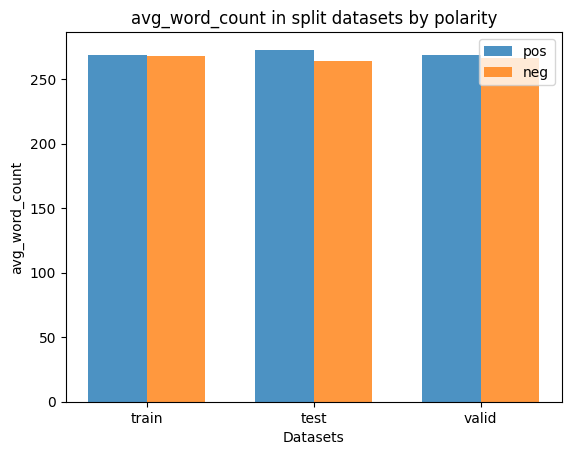

In [ ]:
plot_avg_word_count_combined(results, 'avg_word_count')

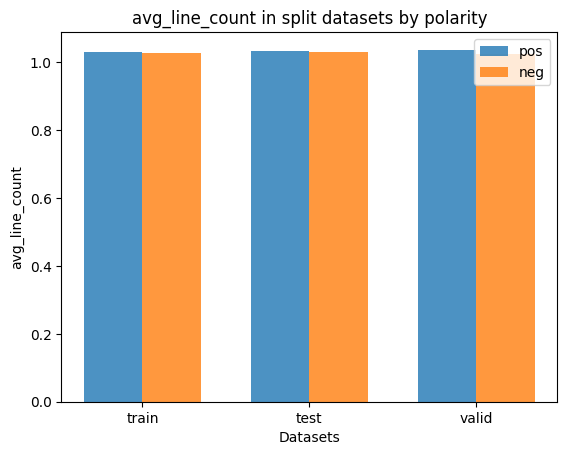

In [ ]:
plot_avg_word_count_combined(results, 'avg_line_count')

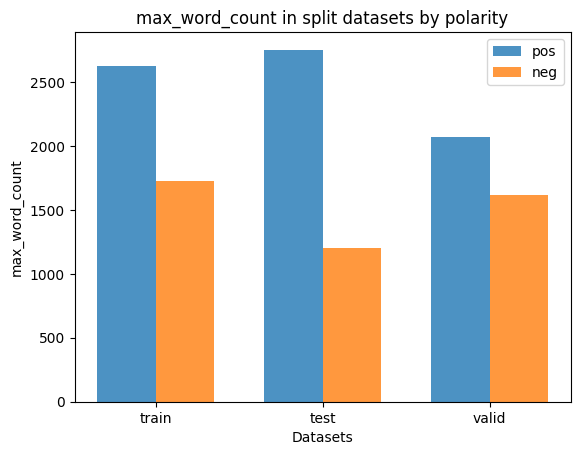

In [ ]:
plot_avg_word_count_combined(results, 'max_word_count')

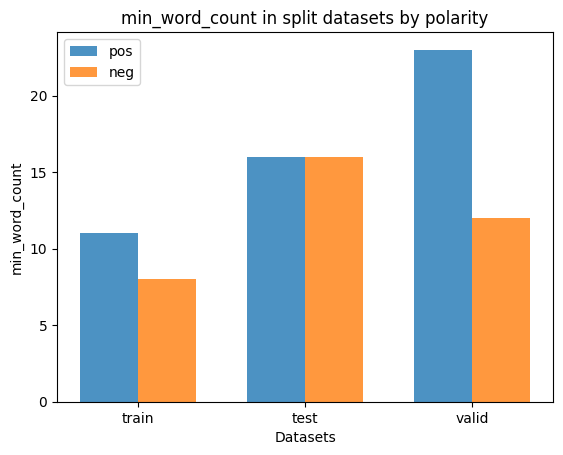

In [ ]:
plot_avg_word_count_combined(results, 'min_word_count')

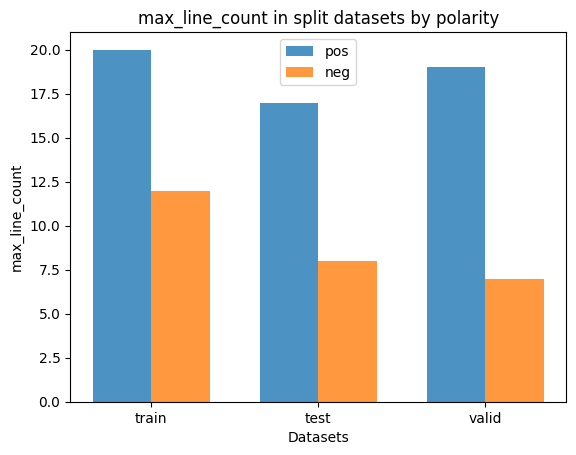

In [ ]:
plot_avg_word_count_combined(results, 'max_line_count')

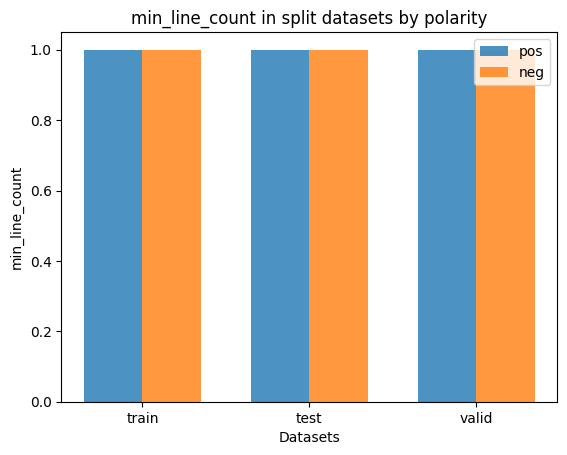

In [ ]:
plot_avg_word_count_combined(results, 'min_line_count')

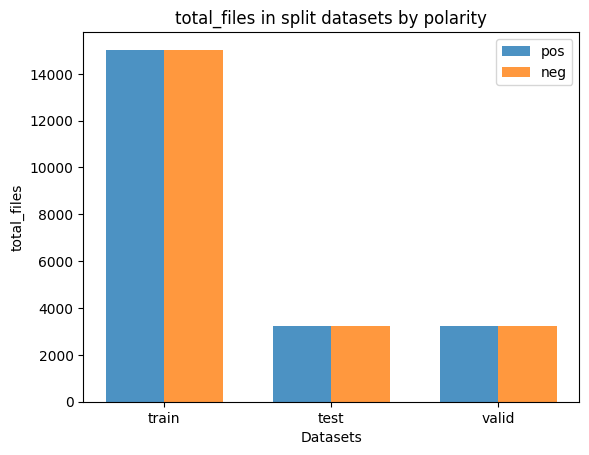

In [ ]:
plot_avg_word_count_combined(results, 'total_files')

In [ ]:
def generate_word_cloud(folder_path):
    text = ""
    for file_path in glob(os.path.join(folder_path, '*.txt')):
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            words = tokenizer(content)
            words = [word for word in words if word in vocab]
            content = ' '.join(words)
            text += content + ' '

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {folder_path}')
    plt.show()


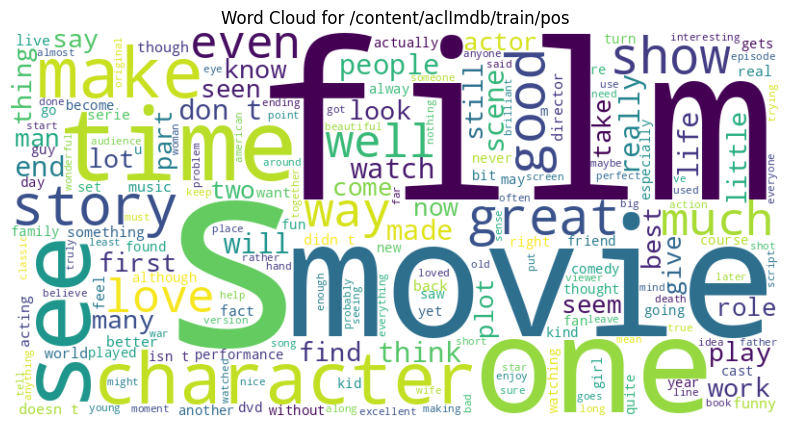

In [ ]:
generate_word_cloud(dataset_path+ '/train/pos')

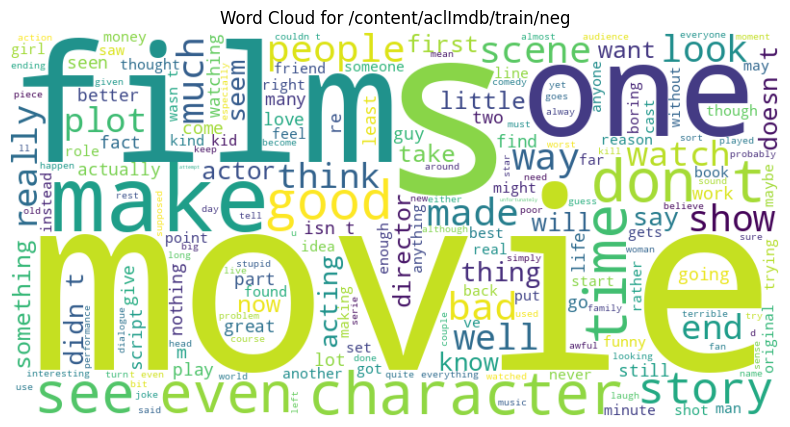

In [ ]:
generate_word_cloud(dataset_path+ '/train/neg')

In [20]:
def pad_sequence(seq, max_len=300):
    if len(seq) > max_len:
        return seq[:max_len]
    else:
        return seq + [vocab.stoi['<pad>']] * (max_len - len(seq))

In [21]:
# Word2Vec embedding
embedding_size = 300
max_seq_length = 300
train_texts = []
for dir in ['pos', 'neg']:
    for file_path in glob(os.path.join(train_dir + '/' + dir, '*.txt')):
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            train_texts.append(content)

tokenized_comments = [tokenizer(train_text) for train_text in train_texts]

word2vec_model = Word2Vec(sentences=tokenized_comments,
                            vector_size=embedding_size,
                            max_final_vocab = 40000,
                            window = 5,
                            workers=4,
                            sg=0,
                            epochs=20)

In [22]:
word2vec_model.wv.most_similar('bad')

[('horrible', 0.6116793751716614),
 ('terrible', 0.6024979948997498),
 ('good', 0.6011735200881958),
 ('awful', 0.5899994969367981),
 ('dreadful', 0.5456486344337463),
 ('atrocious', 0.5421978235244751),
 ('lame', 0.5260753035545349),
 ('stupid', 0.5092319250106812),
 ('lousy', 0.5062355995178223),
 ('ludicrous', 0.47756487131118774)]

In [23]:
word2vec_model.wv.most_similar('good')

[('decent', 0.6375113129615784),
 ('bad', 0.601173460483551),
 ('great', 0.5710731744766235),
 ('nice', 0.5340845584869385),
 ('funny', 0.5201479196548462),
 ('fine', 0.5135093927383423),
 ('lousy', 0.497516393661499),
 ('cool', 0.49486401677131653),
 ('lame', 0.4875461161136627),
 ('weak', 0.4862847626209259)]

In [24]:
word2vec_model.wv.most_similar('great')

[('wonderful', 0.6335229277610779),
 ('fantastic', 0.6231384873390198),
 ('terrific', 0.6130710244178772),
 ('superb', 0.6105239987373352),
 ('excellent', 0.5959286689758301),
 ('fine', 0.5753574371337891),
 ('good', 0.5710732340812683),
 ('brilliant', 0.5613479614257812),
 ('outstanding', 0.5428591966629028),
 ('phenomenal', 0.5219731330871582)]

In [25]:
class IMDBDataset(Dataset):
    def __init__(self, root_dir, tokenizer, vocab, max_seq_length, word2vec_model, load_and_embed = True):
        self.root_dir = root_dir
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.max_seq_length = max_seq_length
        self.word2vec_model = word2vec_model
        self.load_and_embed = load_and_embed
        if self.load_and_embed:
            self.data, self.labels = self.load_and_embed_data()
        else:
            self.data, self.labels = self.load_data()

    def load_data(self):
        data = []
        labels = []
        classes = os.listdir(self.root_dir)
        for class_name in classes:
            class_path = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_path):
                files = os.listdir(class_path)
                for file_name in files:
                    file_path = os.path.join(class_path, file_name)
                    with open(file_path, 'r', encoding='utf-8') as file:
                        text = file.read()
                        data.append(text)
                        # Assign label 0 for 'neg' and 1 for 'pos'
                        label = 0 if class_name == 'neg' else 1
                        labels.append(label)
        return data, labels

    def load_and_embed_data(self):
        data = []
        labels = []
        classes = os.listdir(self.root_dir)
        for class_name in classes:
            class_path = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_path):
                files = os.listdir(class_path)
                for file_name in files:
                    file_path = os.path.join(class_path, file_name)
                    with open(file_path, 'r', encoding='utf-8') as file:
                        text = file.read()
                        data.append(self.embedding(text))
                        # Assign label 0 for 'neg' and 1 for 'pos'
                        label = 0 if class_name == 'neg' else 1
                        labels.append(label)
        return data, labels

    def tokenize(self, text):
        tokens = self.tokenizer(text)
        return tokens

    def pad_sequence(self, text):
        if len(text) > self.max_seq_length:
            return text[:self.max_seq_length]
        else:
            return text + self.vocab.forward(['<pad>']) * (self.max_seq_length - len(text))

    def embedding(self, text):
        word2vec_output = [self.word2vec_model.wv[word] for word in self.tokenize(text) if word in self.word2vec_model.wv]
        if len(word2vec_output) < self.max_seq_length:
            padding = [np.zeros(self.word2vec_model.vector_size)] * (self.max_seq_length - len(word2vec_output))
            word2vec_output += padding
        else:
            word2vec_output = word2vec_output[:self.max_seq_length]
        return word2vec_output

    def __len__(self):
        return len(self.data)

    def __getitem__(self, indices):
        if isinstance(indices, int):
            indices = [indices]
        elif isinstance(indices, slice):
            indices = list(range(*indices.indices(len(self))))

        if not self.load_and_embed:
            samples = {'text': np.stack([self.embedding(self.data[idx]) for idx in indices], axis=0), 'label': [self.labels[idx] for idx in indices]}
        else:
            samples = {'text': np.stack([self.data[idx] for idx in indices], axis=0), 'label': [self.labels[idx] for idx in indices]}
        samples['text'] = torch.tensor(samples['text'], dtype=torch.float32)
        samples['label'] = torch.tensor(samples['label'], dtype=torch.float32)
        return samples

    def collate_fn(self, batch):
        texts = torch.stack([item['text'] for item in batch]).squeeze(dim=1)
        labels = torch.tensor([item['label'] for item in batch]).view(-1, 1)
        return {'text': texts, 'label': labels}

In [26]:
train_dataset = IMDBDataset(train_dir, tokenizer, vocab, max_seq_length = max_seq_length, word2vec_model = word2vec_model, load_and_embed = True)
test_dataset = IMDBDataset(test_dir, tokenizer, vocab, max_seq_length = max_seq_length, word2vec_model = word2vec_model, load_and_embed = True)
valid_dataset = IMDBDataset(valid_dir, tokenizer, vocab, max_seq_length = max_seq_length, word2vec_model = word2vec_model, load_and_embed = True)

In [27]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, collate_fn=train_dataset.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=test_dataset.collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=valid_dataset.collate_fn)

In [28]:
train_dataset_size = len(train_loader.dataset)
test_dataset_size = len(test_loader.dataset)
validation_dataset_size = len(valid_loader.dataset)

print("Train Dataset Size : {}".format(train_dataset_size))
print("Validation Dataset Size : {}".format(validation_dataset_size))
print("Test Dataset Size : {}".format(test_dataset_size))

Train Dataset Size : 30051
Validation Dataset Size : 6438
Test Dataset Size : 6438


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [30]:
class ModelTrial():
    def __init__(self, model, criterion, optimizer, scheduler, l1_lambda = 0):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_metrics = {'accuracy': [], 'loss': []}
        self.validation_metrics = {'accuracy': [], 'loss': []}
        self.test_metrics = {'accuracy': [], 'loss': []}
        self.train_time = None
        self.epochs = []
        self.test_outputs = {}
        self.l1_lambda = l1_lambda
    def printModel(self):
        print(self.model)
    def printModelSummary(self, input_size):
        print(torchinfo.summary(self.model, input_size = input_size))
    def trainingLoop(self, trainLoader, validationLoader, num_epochs, temp_model_path, final_model_path, trial_save_path, verbose = True, lr_scheduler = True, early_stop = True, patience = 10):
        self.train_metrics = {'accuracy': [], 'loss': []}
        self.validation_metrics = {'accuracy': [], 'loss': []}
        self.test_metrics = {'accuracy': [], 'loss': []}
        self.test_outputs = {}
        self.epochs = range(1, num_epochs+1)
        cumulative_train_time = datetime.timedelta()
        min_validation_loss = float('inf')
        patience_ctr = 0
        break_epoch = self.epochs[-1]
        for epoch in self.epochs:
            print(f"In Epoch {epoch}")
            training_loss = 0.0
            training_correct = 0
            t1 = datetime.datetime.now()
            self.model.train()
            for batch_idx, batch_data in enumerate(tqdm(trainLoader)):
                inputs = batch_data['text'].squeeze(dim=1).to(device)
                labels = batch_data['label'].to(device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                y_pred = torch.round(outputs)
                loss = self.criterion(outputs, labels)
                if self.l1_lambda:
                    l1_reg = torch.tensor(0., requires_grad=True)
                    for param in self.model.parameters():
                        l1_reg = l1_reg + torch.norm(param, 1)
                    loss = loss + self.l1_lambda * l1_reg

                loss.backward()
                self.optimizer.step()
                training_loss += loss.item() / (train_dataset_size / trainLoader.batch_size)
                training_correct += (y_pred == labels).sum().item()

            t2 = datetime.datetime.now()
            cumulative_train_time += t2-t1

            training_accuracy = 100 * training_correct / train_dataset_size
            if verbose:
                print(f"Epoch {epoch}, Training Loss: {training_loss:.5f}, Training Accuracy: {training_accuracy:.2f}%")
            self.train_metrics['accuracy'].append(training_accuracy)
            self.train_metrics['loss'].append(training_loss)
            # Validation loop
            validation_loss = 0.0
            validation_correct = 0
            self.model.eval()
            with torch.no_grad():  # Disable gradient computation
                for batch_idx, batch_data in enumerate(tqdm(validationLoader)):
                    inputs = batch_data['text'].squeeze(dim=1).to(device)
                    labels = batch_data['label'].to(device)
                    outputs = self.model(inputs)
                    y_pred = torch.round(outputs)
                    loss = self.criterion(outputs, labels)
                    validation_loss += loss.item() / (validation_dataset_size / validationLoader.batch_size)

                    validation_correct += (y_pred == labels).sum().item()
                validation_accuracy = 100 * validation_correct / validation_dataset_size
                if verbose:
                    print(f"Epoch {epoch}, Validation Loss: {validation_loss:.5f}, Validation Accuracy: {validation_accuracy:.2f}%")
                self.validation_metrics['accuracy'].append(validation_accuracy)
                self.validation_metrics['loss'].append(validation_loss)
            if lr_scheduler:
                self.scheduler.step(validation_loss)
            if early_stop:
                if validation_loss <= min_validation_loss:
                    min_validation_loss = validation_loss
                    patience_counter = 0
                    self.saveModel(temp_model_path)
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print("\nEarly stopping")
                        break_epoch = epoch
                        self.loadModel(temp_model_path)
                        break
        self.epochs = self.epochs[:break_epoch]
        self.train_time = cumulative_train_time
        print("Training Ended !!!")
        self.saveModel(final_model_path)
        self.saveTrial(trial_save_path)

    def testDatasetPass(self, testLoader):
        self.model.eval()
        test_loss = 0.0
        test_correct = 0
        test_labels = torch.Tensor([]).to(device)
        test_pred = torch.Tensor([]).to(device)
        test_outputs = torch.Tensor([]).to(device)
        print(f"Testing Started!")
        with torch.no_grad():
            for batch_idx, batch_data in enumerate(tqdm(testLoader)):
                inputs = batch_data['text'].squeeze(dim=1).to(device)
                labels = batch_data['label'].to(device)
                outputs = self.model(inputs)
                y_pred = torch.round(outputs)
                loss = self.criterion(outputs, labels)
                test_loss += loss.item() / (test_dataset_size / testLoader.batch_size)
                test_correct += (y_pred == labels).sum().item()
                test_labels = torch.cat((test_labels,labels),dim = 0)
                test_pred = torch.cat((test_pred,y_pred), dim = 0)
                test_outputs = torch.cat((test_outputs,outputs), dim = 0)

        test_accuracy = 100 * test_correct / test_dataset_size
        self.test_metrics['accuracy'] = [test_accuracy]*(len(self.epochs))
        self.test_metrics['loss'] = [test_loss]*(len(self.epochs))
        self.test_outputs['accuracy'] = test_accuracy
        self.test_outputs['labels'] = test_labels
        self.test_outputs['y_pred'] = test_pred
        self.test_outputs['outputs'] = test_outputs
        print(f"Testing Completed!!")
        print(f"Testing Loss: {test_loss:.5f}, Testing Accuracy: {test_accuracy:.2f}%")

    def printTrainTimeStatistics(self):
        print("Time taken to train model (train phase alone considered) is : ")
        days = self.train_time.days
        seconds = self.train_time.seconds
        microseconds = self.train_time.microseconds
        hours, remainder = divmod(seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f"Days: {days}, Hours: {hours}, Minutes: {minutes}, Seconds: {seconds}, Microseconds: {microseconds}")

    def plotLossVsEpochs(self):
        fig = plt.figure()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        plt.plot(self.epochs, self.test_metrics['loss'], label = 'Test')
        plt.plot(self.epochs, self.validation_metrics['loss'], label = 'Validation')
        plt.plot(self.epochs, self.train_metrics['loss'], label = 'Train')

        plt.title('Loss vs Epochs graph for Train, Test and Validation Dataset')
        plt.legend()
        plt.show()

    def plotAccuracyVsEpochs(self):
        fig = plt.figure()
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')

        plt.plot(self.epochs, self.test_metrics['accuracy'], label = 'Test')
        plt.plot(self.epochs, self.validation_metrics['accuracy'], label = 'Validation')
        plt.plot(self.epochs, self.train_metrics['accuracy'], label = 'Train')

        plt.title('Accuracy vs Epochs graph for Train, Test and Validation Dataset')
        plt.legend()
        plt.show()

    def printMetrics(self):
        precision, recall, fscore, _ = precision_recall_fscore_support(y_true = self.test_outputs['labels'].cpu().numpy(), y_pred = self.test_outputs['y_pred'].cpu().numpy(), average='binary')
        print(f"Accuracy for Test Dataset at end of training : {self.test_outputs['accuracy']:.5f}")
        print(f"For Test Dataset: Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={fscore:.4f}")

    def plotConfusionMatrix(self):
        bcm = ConfusionMatrix(task="binary", num_classes=2).to(device)
        bcm.update(self.test_outputs['y_pred'], self.test_outputs['labels'])
        fig, ax = plt.subplots()
        bcm.plot(ax = ax)
        plt.title('Confusion Matrix for Test Dataset')
        plt.plot()

    def plotROCgraph(self):
        broc = ROC(task="binary")
        broc.update(self.test_outputs['outputs'], self.test_outputs['labels'].type(torch.int64))
        fig, ax = plt.subplots()
        broc.plot(score=True, ax = ax)
        plt.title('ROC Curve for Test Dataset')
        plt.show()

    def saveModel(self, path):
        torch.save(self.model.state_dict(), path)

    def loadModel(self, path):
        loadedModel = torch.load(path)
        self.model.load_state_dict(loadedModel)

    def saveTrial(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self, f)

    def loadTrial(self, path):
        with open(path, 'rb') as f:
            self = pickle.load(f)

# Base LSTM Model with optimized Setup and Hyperparameters

In [68]:
lr=0.01
num_epochs = 20
l1_lambda = 0
l2_lambda = 1e-4
early_stop = True
earlyStopPatience = 10
lr_scheduler = True
lrsPatience = 5
dropoutProb = 0.2
recurrentDropoutProb = 0.2
bidirectional = False
num_layers = 3
hidden_size = 100
temp_model_path = '/content/sentimentanalysis/base_temp.pth'
final_model_path = '/content/sentimentanalysis/base.pth'
trial_save_path = '/content/sentimentanalysis/base.pkl'

In [94]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=100, num_layers=3, dropout=0, recurrent_dropout=0, bidirectional = False):
        super(CustomLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=bidirectional,
                            dropout=recurrent_dropout)

        self.fc1 = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, 50)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x.mean(dim=1)
        x = self.fc1(x)
        x = nnF.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = nnF.sigmoid(x)
        return x

In [95]:
baseLSTM = CustomLSTM(input_size=embedding_size,
                      hidden_size=hidden_size,
                      num_layers=num_layers,
                      dropout=dropoutProb,
                      recurrent_dropout=recurrentDropoutProb,
                      bidirectional=bidirectional)
criterion = nn.BCELoss()
optimizer = optim.Adam(baseLSTM.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, threshold_mode = 'rel', mode = 'min', patience=lrsPatience, threshold=0.0001)

In [96]:
baseLSTMModel = ModelTrial(baseLSTM, criterion, optimizer, scheduler = scheduler, l1_lambda = l1_lambda)

In [97]:
baseLSTMModel.printModel()

CustomLSTM(
  (lstm): LSTM(300, 100, num_layers=3, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


In [98]:
baseLSTMModel.printModelSummary((256, max_seq_length, embedding_size))

Layer (type:depth-idx)                   Output Shape              Param #
CustomLSTM                               [256, 1]                  --
├─LSTM: 1-1                              [256, 300, 100]           322,400
├─Linear: 1-2                            [256, 50]                 5,050
├─Dropout: 1-3                           [256, 50]                 --
├─Linear: 1-4                            [256, 1]                  51
Total params: 327,501
Trainable params: 327,501
Non-trainable params: 0
Total mult-adds (G): 24.76
Input size (MB): 92.16
Forward/backward pass size (MB): 61.54
Params size (MB): 1.31
Estimated Total Size (MB): 155.01


In [99]:
baseLSTMModel.trainingLoop(trainLoader = train_loader, validationLoader = valid_loader,
                         num_epochs = num_epochs,
                         temp_model_path = temp_model_path,
                         final_model_path = final_model_path,
                         trial_save_path = trial_save_path,
                         verbose = True, lr_scheduler = lr_scheduler,
                         early_stop = early_stop, patience = earlyStopPatience)

In Epoch 1


100%|██████████| 118/118 [00:21<00:00,  5.60it/s]


Epoch 1, Training Loss: 0.43566, Training Accuracy: 79.48%


100%|██████████| 202/202 [00:03<00:00, 58.70it/s]


Epoch 1, Validation Loss: 0.39234, Validation Accuracy: 84.17%
In Epoch 2


100%|██████████| 118/118 [00:20<00:00,  5.85it/s]


Epoch 2, Training Loss: 0.28139, Training Accuracy: 88.46%


100%|██████████| 202/202 [00:03<00:00, 57.83it/s]


Epoch 2, Validation Loss: 0.26329, Validation Accuracy: 89.10%
In Epoch 3


100%|██████████| 118/118 [00:20<00:00,  5.69it/s]


Epoch 3, Training Loss: 0.22821, Training Accuracy: 91.05%


100%|██████████| 202/202 [00:03<00:00, 55.68it/s]


Epoch 3, Validation Loss: 0.24988, Validation Accuracy: 90.21%
In Epoch 4


100%|██████████| 118/118 [00:20<00:00,  5.75it/s]


Epoch 4, Training Loss: 0.19687, Training Accuracy: 92.55%


100%|██████████| 202/202 [00:03<00:00, 56.32it/s]


Epoch 4, Validation Loss: 0.27712, Validation Accuracy: 89.13%
In Epoch 5


100%|██████████| 118/118 [00:20<00:00,  5.80it/s]


Epoch 5, Training Loss: 0.17895, Training Accuracy: 93.13%


100%|██████████| 202/202 [00:03<00:00, 53.26it/s]


Epoch 5, Validation Loss: 0.26088, Validation Accuracy: 89.98%
In Epoch 6


100%|██████████| 118/118 [00:20<00:00,  5.86it/s]


Epoch 6, Training Loss: 0.15971, Training Accuracy: 94.01%


100%|██████████| 202/202 [00:03<00:00, 56.86it/s]


Epoch 6, Validation Loss: 0.26304, Validation Accuracy: 89.97%
In Epoch 7


100%|██████████| 118/118 [00:20<00:00,  5.84it/s]


Epoch 7, Training Loss: 0.14387, Training Accuracy: 94.63%


100%|██████████| 202/202 [00:03<00:00, 56.28it/s]


Epoch 7, Validation Loss: 0.27910, Validation Accuracy: 89.64%
In Epoch 8


100%|██████████| 118/118 [00:20<00:00,  5.81it/s]


Epoch 8, Training Loss: 0.13584, Training Accuracy: 95.04%


100%|██████████| 202/202 [00:03<00:00, 57.73it/s]


Epoch 8, Validation Loss: 0.26887, Validation Accuracy: 90.20%
In Epoch 9


100%|██████████| 118/118 [00:20<00:00,  5.82it/s]


Epoch 9, Training Loss: 0.12163, Training Accuracy: 95.46%


100%|██████████| 202/202 [00:03<00:00, 60.63it/s]


Epoch 9, Validation Loss: 0.30797, Validation Accuracy: 89.59%
In Epoch 10


100%|██████████| 118/118 [00:20<00:00,  5.83it/s]


Epoch 10, Training Loss: 0.07288, Training Accuracy: 97.64%


100%|██████████| 202/202 [00:03<00:00, 63.50it/s]


Epoch 10, Validation Loss: 0.36521, Validation Accuracy: 90.09%
In Epoch 11


100%|██████████| 118/118 [00:20<00:00,  5.87it/s]


Epoch 11, Training Loss: 0.04777, Training Accuracy: 98.44%


100%|██████████| 202/202 [00:03<00:00, 63.28it/s]


Epoch 11, Validation Loss: 0.44219, Validation Accuracy: 90.21%
In Epoch 12


100%|██████████| 118/118 [00:20<00:00,  5.84it/s]


Epoch 12, Training Loss: 0.03124, Training Accuracy: 99.06%


100%|██████████| 202/202 [00:03<00:00, 62.68it/s]


Epoch 12, Validation Loss: 0.49223, Validation Accuracy: 90.29%
In Epoch 13


100%|██████████| 118/118 [00:20<00:00,  5.83it/s]


Epoch 13, Training Loss: 0.02272, Training Accuracy: 99.40%


100%|██████████| 202/202 [00:03<00:00, 61.96it/s]


Epoch 13, Validation Loss: 0.59152, Validation Accuracy: 90.14%

Early stopping
Training Ended !!!


In [100]:
baseLSTMModel.testDatasetPass(test_loader)

Testing Started!


100%|██████████| 202/202 [00:03<00:00, 60.94it/s]

Testing Completed!!
Testing Loss: 0.25611, Testing Accuracy: 89.39%


In [101]:
baseLSTMModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 4, Seconds: 24, Microseconds: 671616


In [102]:
baseLSTMModel.printMetrics()

Accuracy for Test Dataset at end of training : 89.39112
For Test Dataset: Precision=0.9101, Recall=0.8742, F1 Score=0.8918


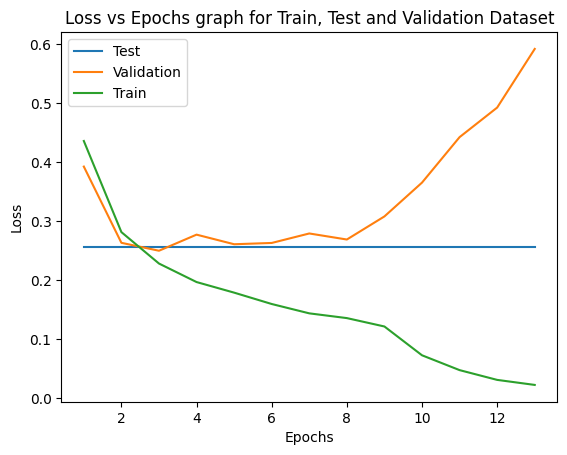

In [103]:
baseLSTMModel.plotLossVsEpochs()

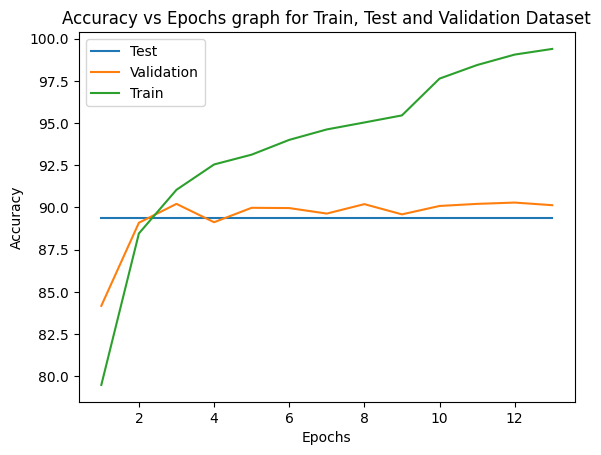

In [104]:
baseLSTMModel.plotAccuracyVsEpochs()

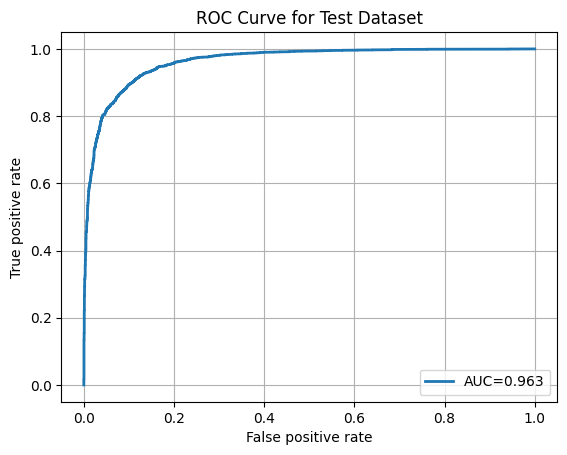

In [105]:
baseLSTMModel.plotROCgraph()

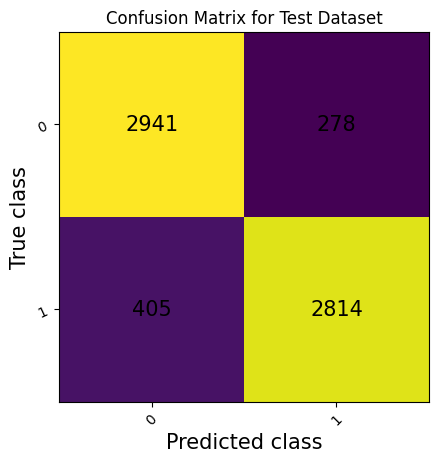

In [106]:
baseLSTMModel.plotConfusionMatrix()

# Bidirectional LSTM Model with optimized Setup and Hyperparameters

In [107]:
lr=0.01
num_epochs = 20
l1_lambda = 0
l2_lambda = 1e-4
early_stop = True
earlyStopPatience = 10
lr_scheduler = True
lrsPatience = 5
dropoutProb = 0.2
recurrentDropoutProb = 0.2
bidirectional = True
num_layers = 3
hidden_size = 100
temp_model_path = '/content/sentimentanalysis/bidirec_temp.pth'
final_model_path = '/content/sentimentanalysis/bidirec.pth'
trial_save_path = '/content/sentimentanalysis/bidirec.pkl'

In [108]:
bidirectionalLSTM = CustomLSTM(input_size=embedding_size,
                      hidden_size=hidden_size,
                      num_layers=num_layers,
                      dropout=dropoutProb,
                      recurrent_dropout=recurrentDropoutProb,
                      bidirectional=bidirectional)
criterion = nn.BCELoss()
optimizer = optim.Adam(bidirectionalLSTM.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, threshold_mode = 'rel', mode = 'min', patience=lrsPatience, threshold=0.0001)

In [109]:
bidirectionalLSTMModel = ModelTrial(bidirectionalLSTM, criterion, optimizer, scheduler = scheduler, l1_lambda = l1_lambda)

In [110]:
bidirectionalLSTMModel.printModel()

CustomLSTM(
  (lstm): LSTM(300, 100, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=200, out_features=50, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


In [111]:
bidirectionalLSTMModel.printModelSummary((256, max_seq_length, embedding_size))

Layer (type:depth-idx)                   Output Shape              Param #
CustomLSTM                               [256, 1]                  --
├─LSTM: 1-1                              [256, 300, 200]           804,800
├─Linear: 1-2                            [256, 50]                 10,050
├─Dropout: 1-3                           [256, 50]                 --
├─Linear: 1-4                            [256, 1]                  51
Total params: 814,901
Trainable params: 814,901
Non-trainable params: 0
Total mult-adds (G): 61.81
Input size (MB): 92.16
Forward/backward pass size (MB): 122.98
Params size (MB): 3.26
Estimated Total Size (MB): 218.40


In [112]:
bidirectionalLSTMModel.trainingLoop(trainLoader = train_loader, validationLoader = valid_loader,
                         num_epochs = num_epochs,
                         temp_model_path = temp_model_path,
                         final_model_path = final_model_path,
                         trial_save_path = trial_save_path,
                         verbose = True, lr_scheduler = lr_scheduler,
                         early_stop = early_stop, patience = earlyStopPatience)

In Epoch 1


100%|██████████| 118/118 [00:22<00:00,  5.14it/s]


Epoch 1, Training Loss: 0.54475, Training Accuracy: 71.26%


100%|██████████| 202/202 [00:03<00:00, 52.54it/s]


Epoch 1, Validation Loss: 0.36467, Validation Accuracy: 84.22%
In Epoch 2


100%|██████████| 118/118 [00:22<00:00,  5.15it/s]


Epoch 2, Training Loss: 0.32752, Training Accuracy: 86.36%


100%|██████████| 202/202 [00:04<00:00, 48.08it/s]


Epoch 2, Validation Loss: 0.30222, Validation Accuracy: 87.42%
In Epoch 3


100%|██████████| 118/118 [00:23<00:00,  5.12it/s]


Epoch 3, Training Loss: 0.25445, Training Accuracy: 89.97%


100%|██████████| 202/202 [00:03<00:00, 52.49it/s]


Epoch 3, Validation Loss: 0.26138, Validation Accuracy: 89.25%
In Epoch 4


100%|██████████| 118/118 [00:23<00:00,  5.10it/s]


Epoch 4, Training Loss: 0.22532, Training Accuracy: 91.42%


100%|██████████| 202/202 [00:03<00:00, 53.65it/s]


Epoch 4, Validation Loss: 0.25464, Validation Accuracy: 89.86%
In Epoch 5


100%|██████████| 118/118 [00:22<00:00,  5.13it/s]


Epoch 5, Training Loss: 0.19833, Training Accuracy: 92.53%


100%|██████████| 202/202 [00:03<00:00, 53.98it/s]


Epoch 5, Validation Loss: 0.30421, Validation Accuracy: 88.23%
In Epoch 6


100%|██████████| 118/118 [00:23<00:00,  5.10it/s]


Epoch 6, Training Loss: 0.17581, Training Accuracy: 93.58%


100%|██████████| 202/202 [00:03<00:00, 50.58it/s]


Epoch 6, Validation Loss: 0.26413, Validation Accuracy: 89.75%
In Epoch 7


100%|██████████| 118/118 [00:23<00:00,  5.11it/s]


Epoch 7, Training Loss: 0.15925, Training Accuracy: 94.23%


100%|██████████| 202/202 [00:03<00:00, 50.52it/s]


Epoch 7, Validation Loss: 0.28563, Validation Accuracy: 88.74%
In Epoch 8


100%|██████████| 118/118 [00:22<00:00,  5.15it/s]


Epoch 8, Training Loss: 0.15038, Training Accuracy: 94.45%


100%|██████████| 202/202 [00:03<00:00, 54.20it/s]


Epoch 8, Validation Loss: 0.30754, Validation Accuracy: 89.38%
In Epoch 9


100%|██████████| 118/118 [00:23<00:00,  5.03it/s]


Epoch 9, Training Loss: 0.12120, Training Accuracy: 95.65%


100%|██████████| 202/202 [00:03<00:00, 53.28it/s]


Epoch 9, Validation Loss: 0.30073, Validation Accuracy: 89.70%
In Epoch 10


100%|██████████| 118/118 [00:23<00:00,  5.08it/s]


Epoch 10, Training Loss: 0.11997, Training Accuracy: 95.66%


100%|██████████| 202/202 [00:03<00:00, 52.82it/s]


Epoch 10, Validation Loss: 0.32126, Validation Accuracy: 89.59%
In Epoch 11


100%|██████████| 118/118 [00:23<00:00,  5.02it/s]


Epoch 11, Training Loss: 0.07689, Training Accuracy: 97.41%


100%|██████████| 202/202 [00:04<00:00, 49.86it/s]


Epoch 11, Validation Loss: 0.36562, Validation Accuracy: 89.81%
In Epoch 12


100%|██████████| 118/118 [00:23<00:00,  5.10it/s]


Epoch 12, Training Loss: 0.04672, Training Accuracy: 98.59%


100%|██████████| 202/202 [00:03<00:00, 52.04it/s]


Epoch 12, Validation Loss: 0.41628, Validation Accuracy: 89.75%
In Epoch 13


100%|██████████| 118/118 [00:23<00:00,  5.06it/s]


Epoch 13, Training Loss: 0.03321, Training Accuracy: 99.10%


100%|██████████| 202/202 [00:03<00:00, 53.38it/s]


Epoch 13, Validation Loss: 0.46953, Validation Accuracy: 89.83%
In Epoch 14


100%|██████████| 118/118 [00:23<00:00,  5.06it/s]


Epoch 14, Training Loss: 0.02436, Training Accuracy: 99.33%


100%|██████████| 202/202 [00:03<00:00, 52.21it/s]


Epoch 14, Validation Loss: 0.52266, Validation Accuracy: 89.75%

Early stopping
Training Ended !!!


In [113]:
bidirectionalLSTMModel.testDatasetPass(test_loader)

Testing Started!


100%|██████████| 202/202 [00:04<00:00, 49.79it/s]

Testing Completed!!
Testing Loss: 0.25539, Testing Accuracy: 89.66%


In [114]:
bidirectionalLSTMModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 5, Seconds: 24, Microseconds: 247828


In [115]:
bidirectionalLSTMModel.printMetrics()

Accuracy for Test Dataset at end of training : 89.65517
For Test Dataset: Precision=0.8844, Recall=0.9124, F1 Score=0.8982


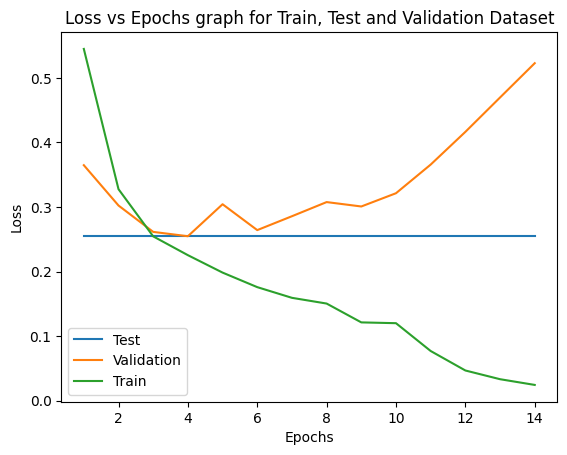

In [116]:
bidirectionalLSTMModel.plotLossVsEpochs()

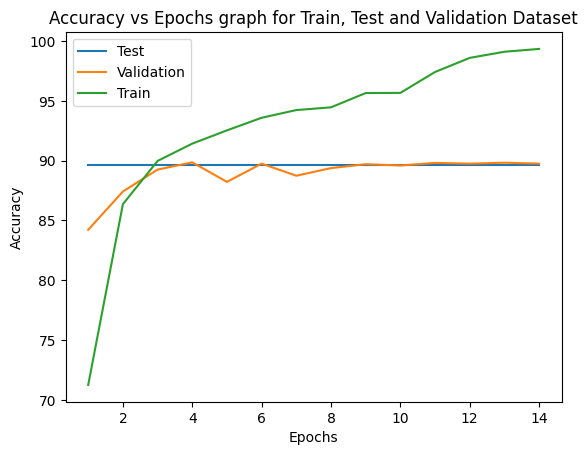

In [117]:
bidirectionalLSTMModel.plotAccuracyVsEpochs()

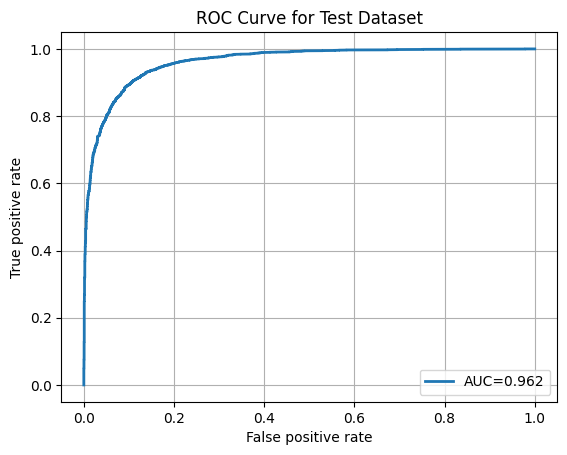

In [118]:
bidirectionalLSTMModel.plotROCgraph()

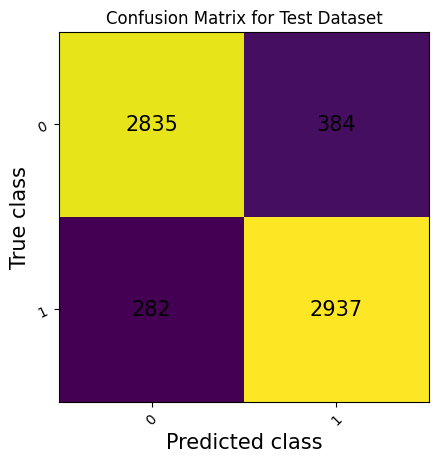

In [119]:
bidirectionalLSTMModel.plotConfusionMatrix()

#### References
1.	https://docs.python.org/3/index.html

2.	https://matplotlib.org/stable/

3.	https://seaborn.pydata.org/api.html

4.	https://pandas.pydata.org/docs/reference/index.html

5.	https://numpy.org/doc/stable/index.html

6.	https://pytorch.org/docs/stable/index.html

7.	https://github.com/TylerYep/torchinfo#readme

8.	https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

9.	https://torchmetrics.readthedocs.io/en/stable/

10.	https://scikit-learn.org/stable/modules/classes.html

11.	https://radimrehurek.com/gensim/auto_examples/index.html#documentation

12. https://pytorch.org/text/stable/index.html

13. Li, S. (2018). Application of Recurrent Neural Networks In Toxic Comment Classification. UCLA. ProQuest ID: Li_ucla_0031N_16645. Merritt ID: ark:/13030/m5nw4fhv. Retrieved from https://escholarship.org/uc/item/5f87h061

14. Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. 2011. Learning word vectors for sentiment analysis. In Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies - Volume 1 (HLT '11). Association for Computational Linguistics, USA, 142–150.